# Automatizovaná detekce rotace DH PSF
_Jakub Dokulil_

## Axiální lokalizace pomocí vírových svazků

Vírové svazky jsou svazky se šroubovitou vlnoplochou. Takový svazek může být generován například při průchodu rovinné vlnoplochy fázovým prvkem, například spirální maskou (SM). Při volbě vhodných vírových svazků může dojít k samozobrazení a formování dvoučetné rozptylové funkce bodu (Double Helix Point Spread Function -- DH PSF). Toho lze využít například při detekci axiální polohy bodového zdroje světla.

Experiment pro detekci axiílní polohy lze vidět například na obrázku níže. Bodový zdroj světla je umístěn do ohniska čočky. Svazek je kolimován a do Fourierovské roviny je umístěna SM vytvářející optické víry. Ty jsou následně zobrazeny pomocí další čočky na kamaru, kde je detekována DH PSF. Pokud dojde k axiálnímu posunu bodového zdroje, tj. dojde k _defokusaci_ $\Delta z$ dochází ke změně tvaru vlnoplochy z roviny na kulový povrch. Tím vzniká fázové zpoždění mezi jednotlivými výry $\Delta \beta_m$. Toto fázové zpoždění způsobí rotaci DH PSF. Rotace je přímo úměrná defokusaci.

![Schéma experimentu](umisteni_masky.png)

Véce například v <div class="csl-entry">Bouchal, P., &#38; Bouchal, Z. (2017). Flexible non-diffractive vortex microscope for three-dimensional depth-enhanced super-localization of dielectric, metal and fluorescent nanoparticles. <i>Journal of Optics (United Kingdom)</i>, <i>19</i>(10). https://doi.org/10.1088/2040-8986/aa87fb</div>

## Zpracování obrazu DH PSF

Pro zpracování byl původně použit následující postup.

1. Prahování obrazu.
2. Převod obrazu na binární mmasku.
3. Pomocí funkce pro hledání kruhů najít kruhy (funkce `hough_circle` knihovny `skimage`).
4. Spořítat úhel spojnice středů kruhů pomocí funkce `arctan2`

Postup však ne vždy dokázal najít správně kruhy. Proto byla použita změa v segmentaci u bodů 3 a 4. Postup vypadá následovně:

1. Prahování obrazu.
2. Převod obrazu na binární mmasku.
3. Označení jednotlivých oblastí (metoda `label` balíku `scipy.ndimage`).
4. Výpočet těžiště jednotlivých oblastí (metoda `centre_of_mass` balíku `scipy.ndimage`)
5. Výpočet úhlu pomocí těžiště.

## Implemetace

Pro implementaci byl vytvořen externí balík `PSFrot`, obsahující funkce pro zpřehlednění kódu. Balík obsahuje následující funkce.

`readImage` - funkce načte obraz, může jej normalizovat (výchozí nastavení) a vrátí pole.

`threshold` - funkce pro prahování. Výhoczí hodnota prahu je 0,4 (pro hodnoty od 0 do 1).

`findCircles` - funkce která najde kruhy v obraze. Lze nastavit maximální a miniimální poloměr hledaných kruhů.

`centresOfMass` - funkce která najde težiště dvou světlých oblastí a spočítá jejich úhel.

Algoritmus byl testován na testovacích obrazcích, které lze vidět níže.

### Import balíků a knihoven

In [1]:
from PSFrot import PSFrot
import proplot as pplt
import numpy as np
from skimage.draw import circle_perimeter
from skimage.color import rgb2gray, gray2rgb
import matplotlib.pyplot as plt
from scipy import ndimage as ndi


### Vykreslení testovacích obrazců

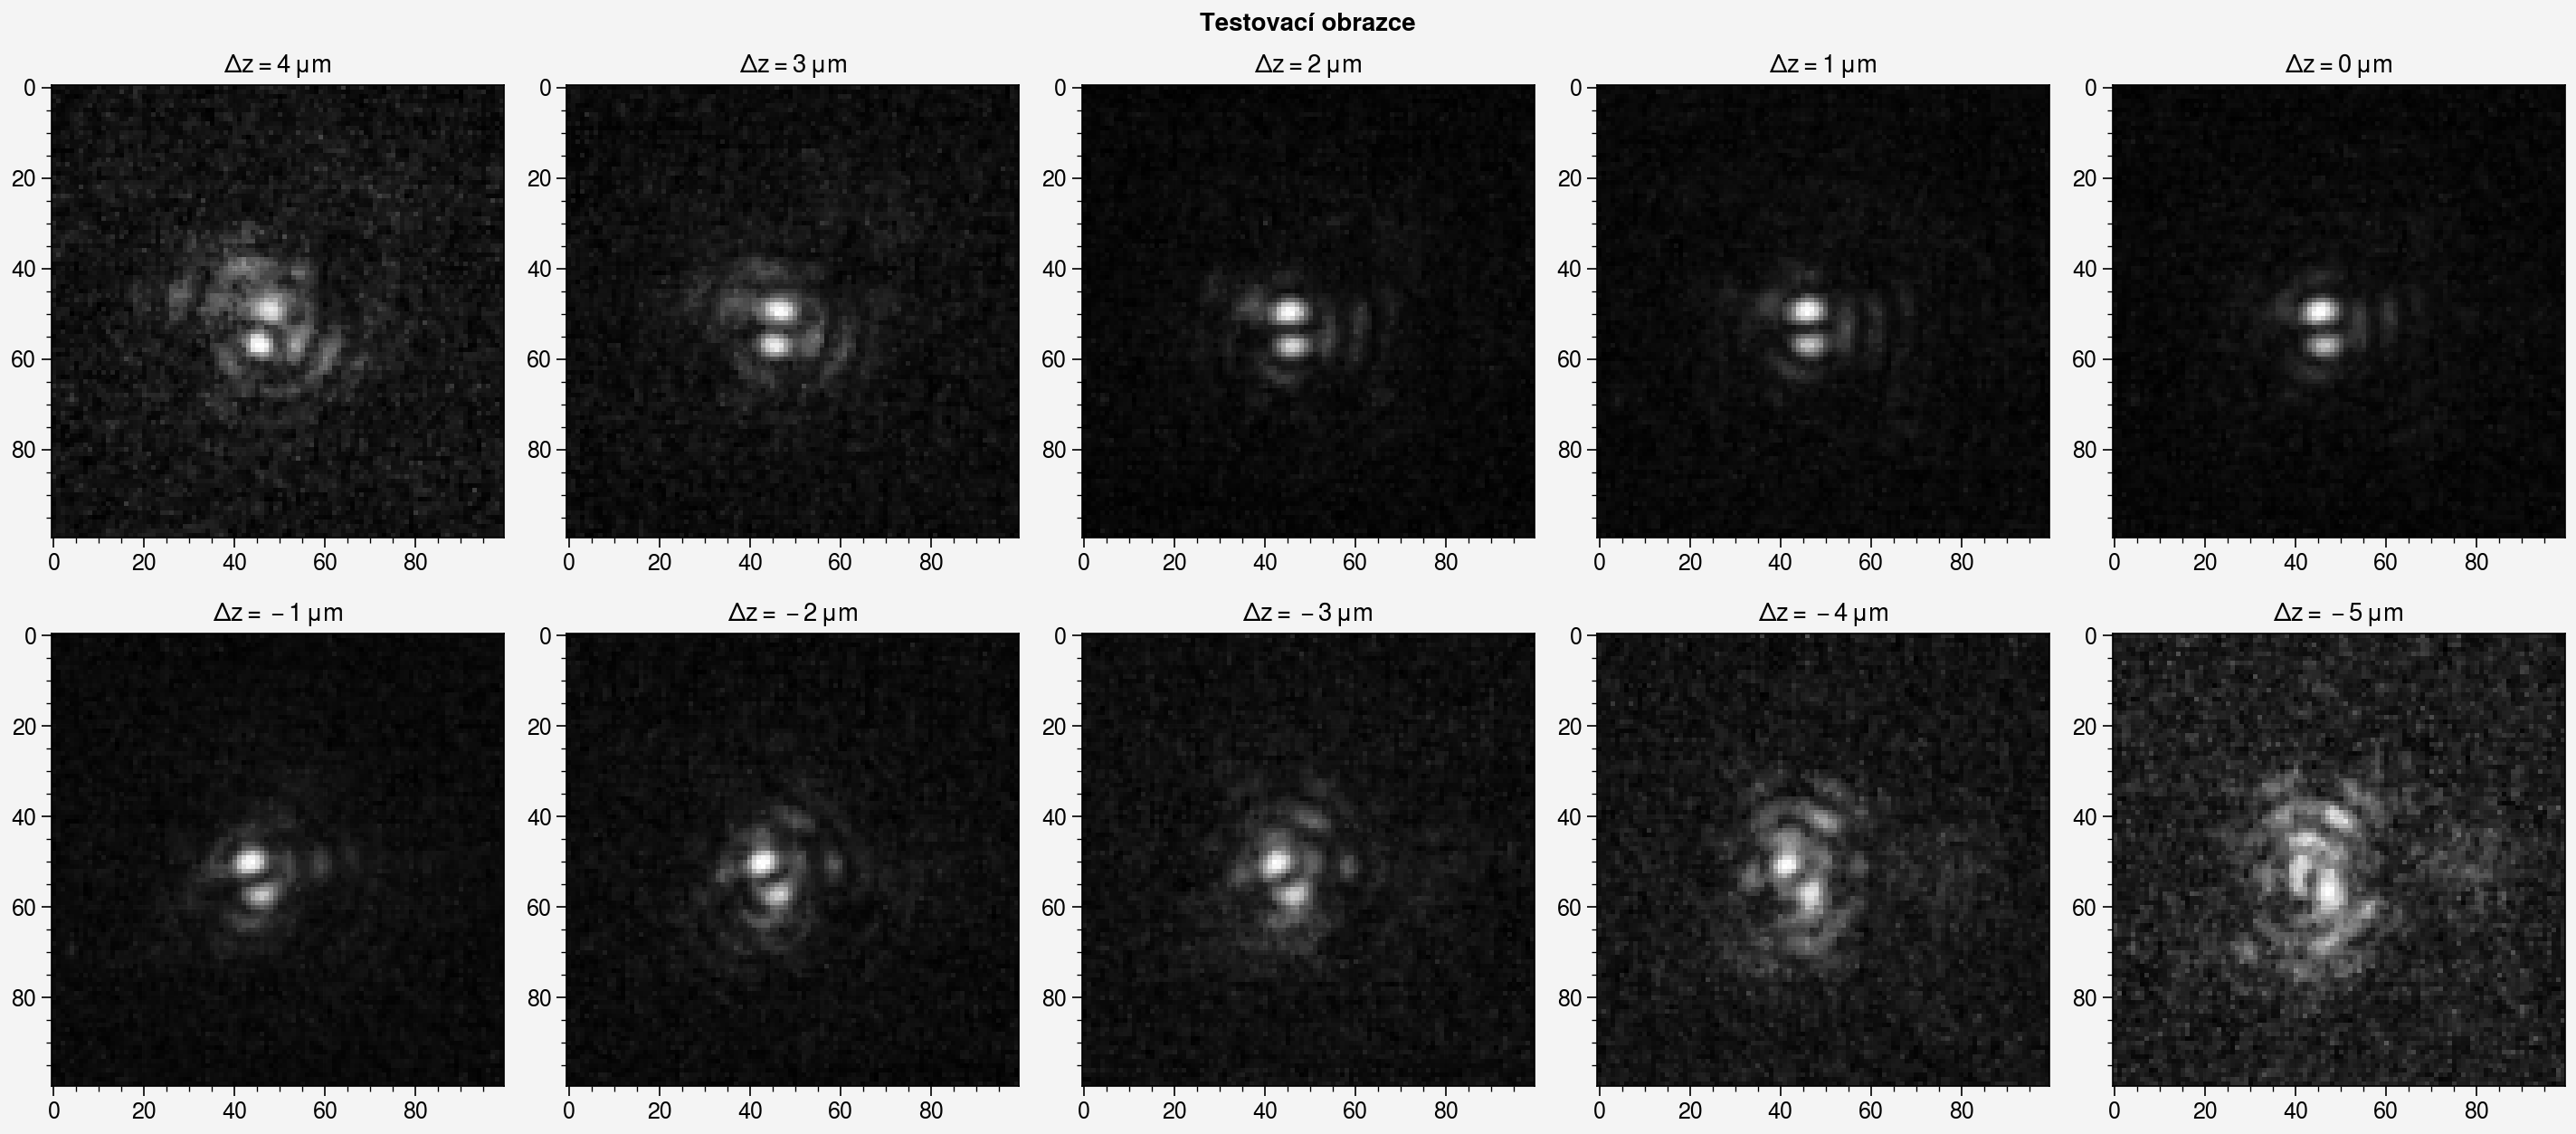

In [2]:
fig, axs = pplt.subplots(nrows=2, ncols=5, share=False,
                         suptitle="Testovací obrazce")


for i in range(-5, 5):
    filename = "test_imgs/" + str(i) + ".tiff"
    image = PSFrot.readImage(path=filename)
    axs[i//5, 4-i % 5].imshow(-image, cmap='Greys')
    axs[i//5, 4-i % 5].format(title="$\Delta z = " + str(i) + " \,\mu m$")

fig.save("test.png", dpi=333)


### Zpracování pomocí první metody

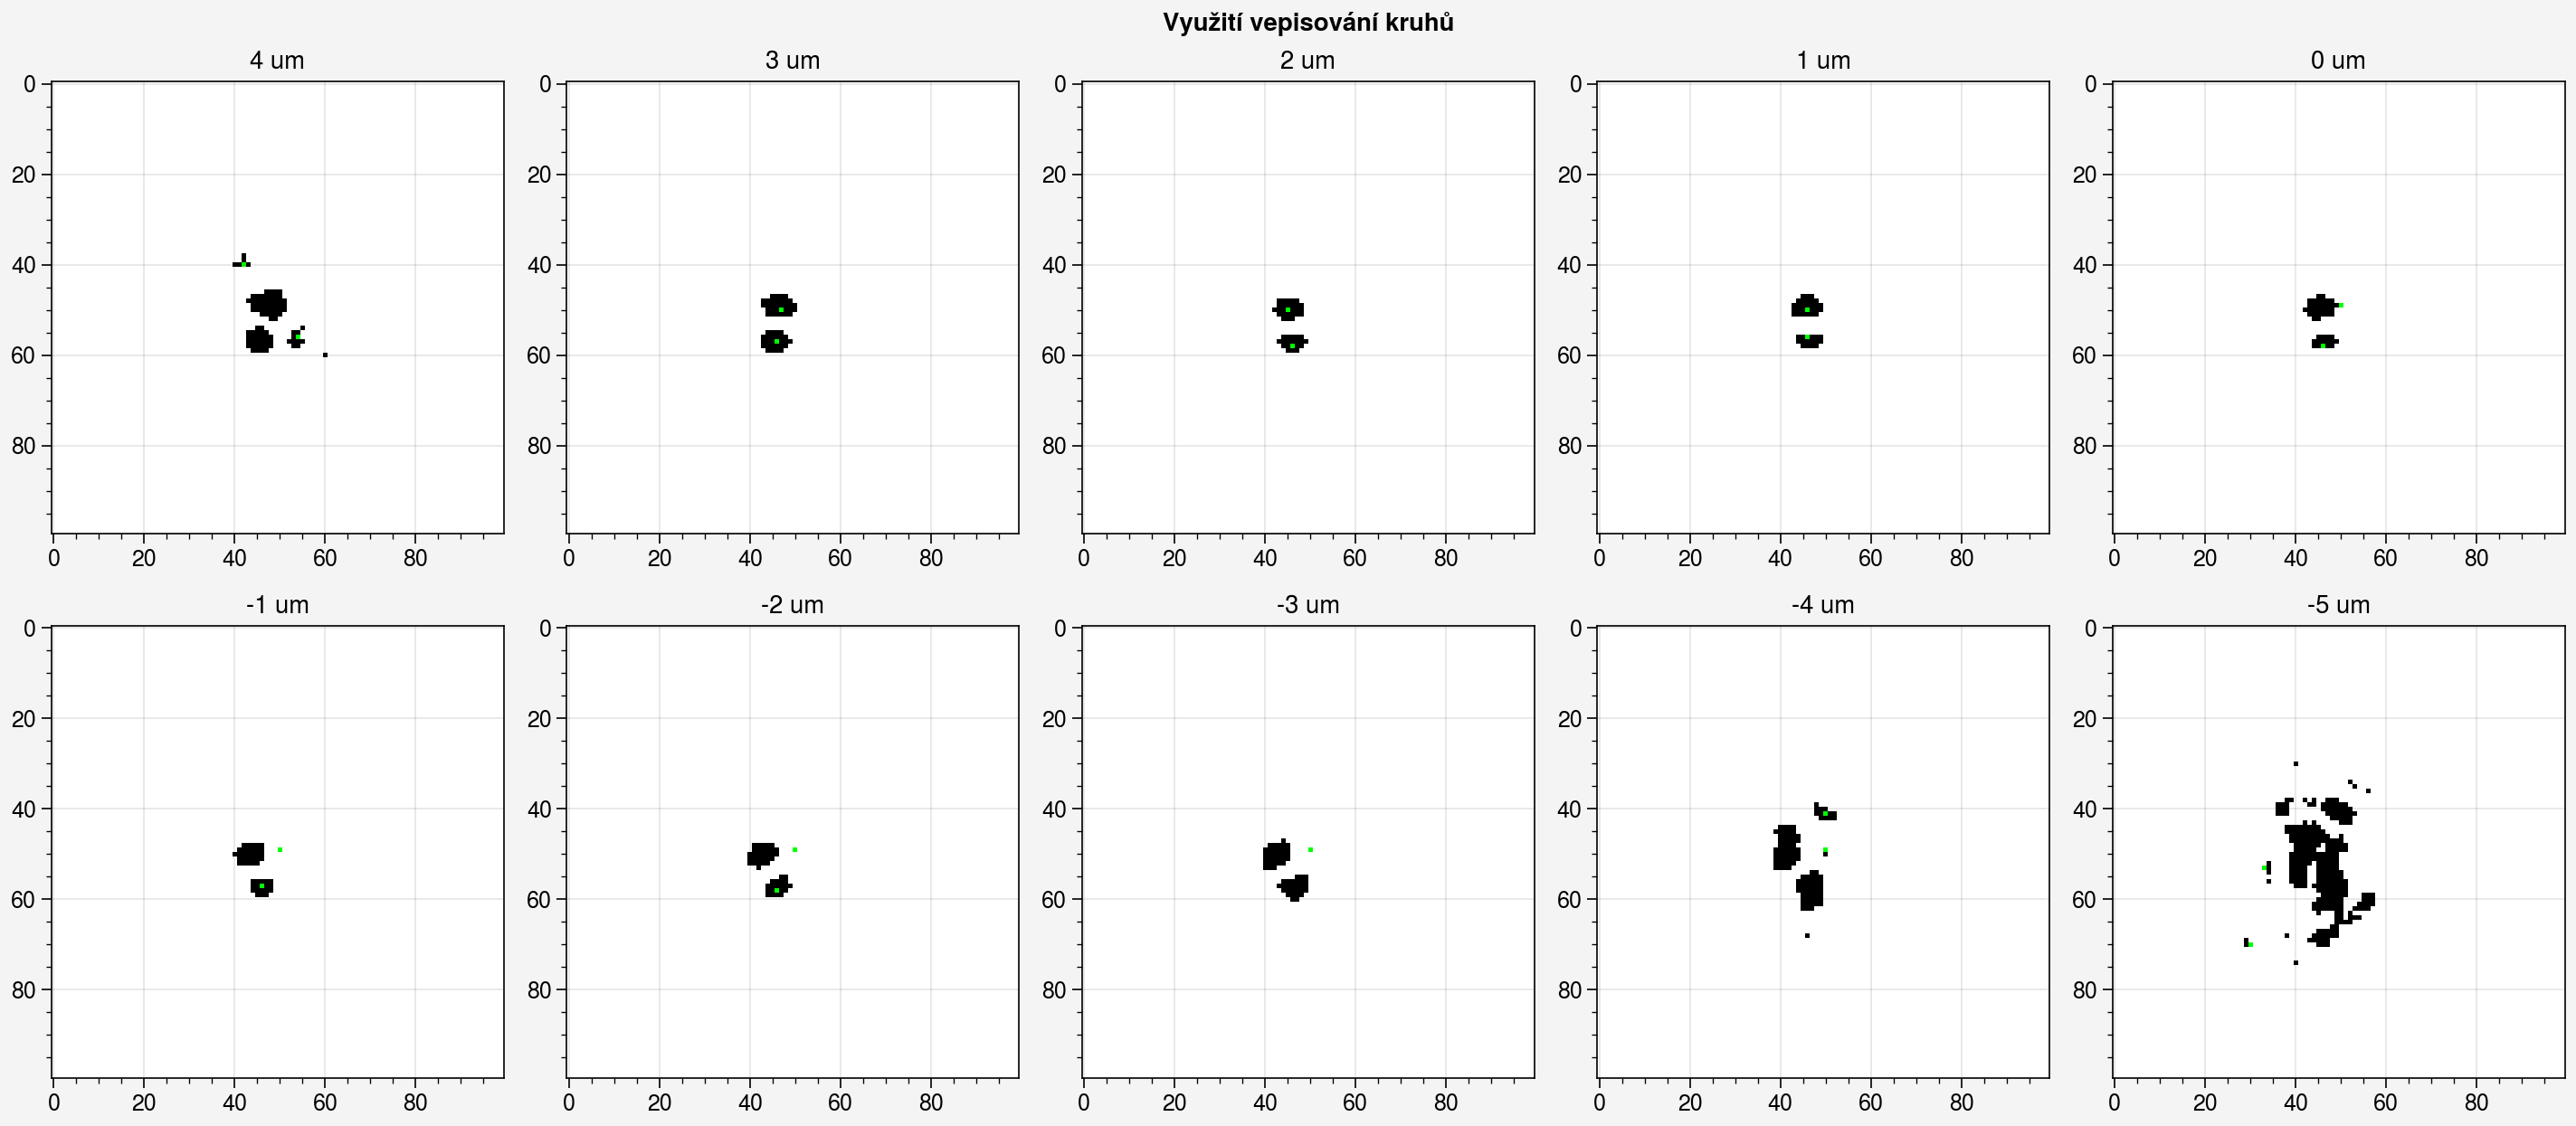

In [3]:
fig, axs = pplt.subplots(nrows=2, ncols=5, share=False,
                         suptitle="Využití vepisování kruhů")

angles = np.zeros(10)

for i in range(-5, 5):
    filename = "test_imgs/" + str(i) + ".tiff"
    image = PSFrot.readImage(path=filename)
    image = PSFrot.threshold(image, intensity=0.4)
    cx, cy, rad = PSFrot.findCircles(image)
    imC = gray2rgb(image)
    for cx, cy in zip(cx, cy):
        imC[cy, cx] = (0, 1., 0)  # zvžraznění středů
    axs[i//5, 4-i % 5].imshow(imC)
    axs[i//5, 4-i % 5].format(title=str(i) + " um")

fig.save("vysl_circ.png", dpi=333)


Lze vidět, že pro defokusaci -1 $\mathrm{\mu m}$ a méně metoda není schopna najít jednotlivé bloby. Ani pro defokusaci 0 $\mathrm{\mu m}$ metoda nenalezla střed.

### Pracování pomocí druhé metody

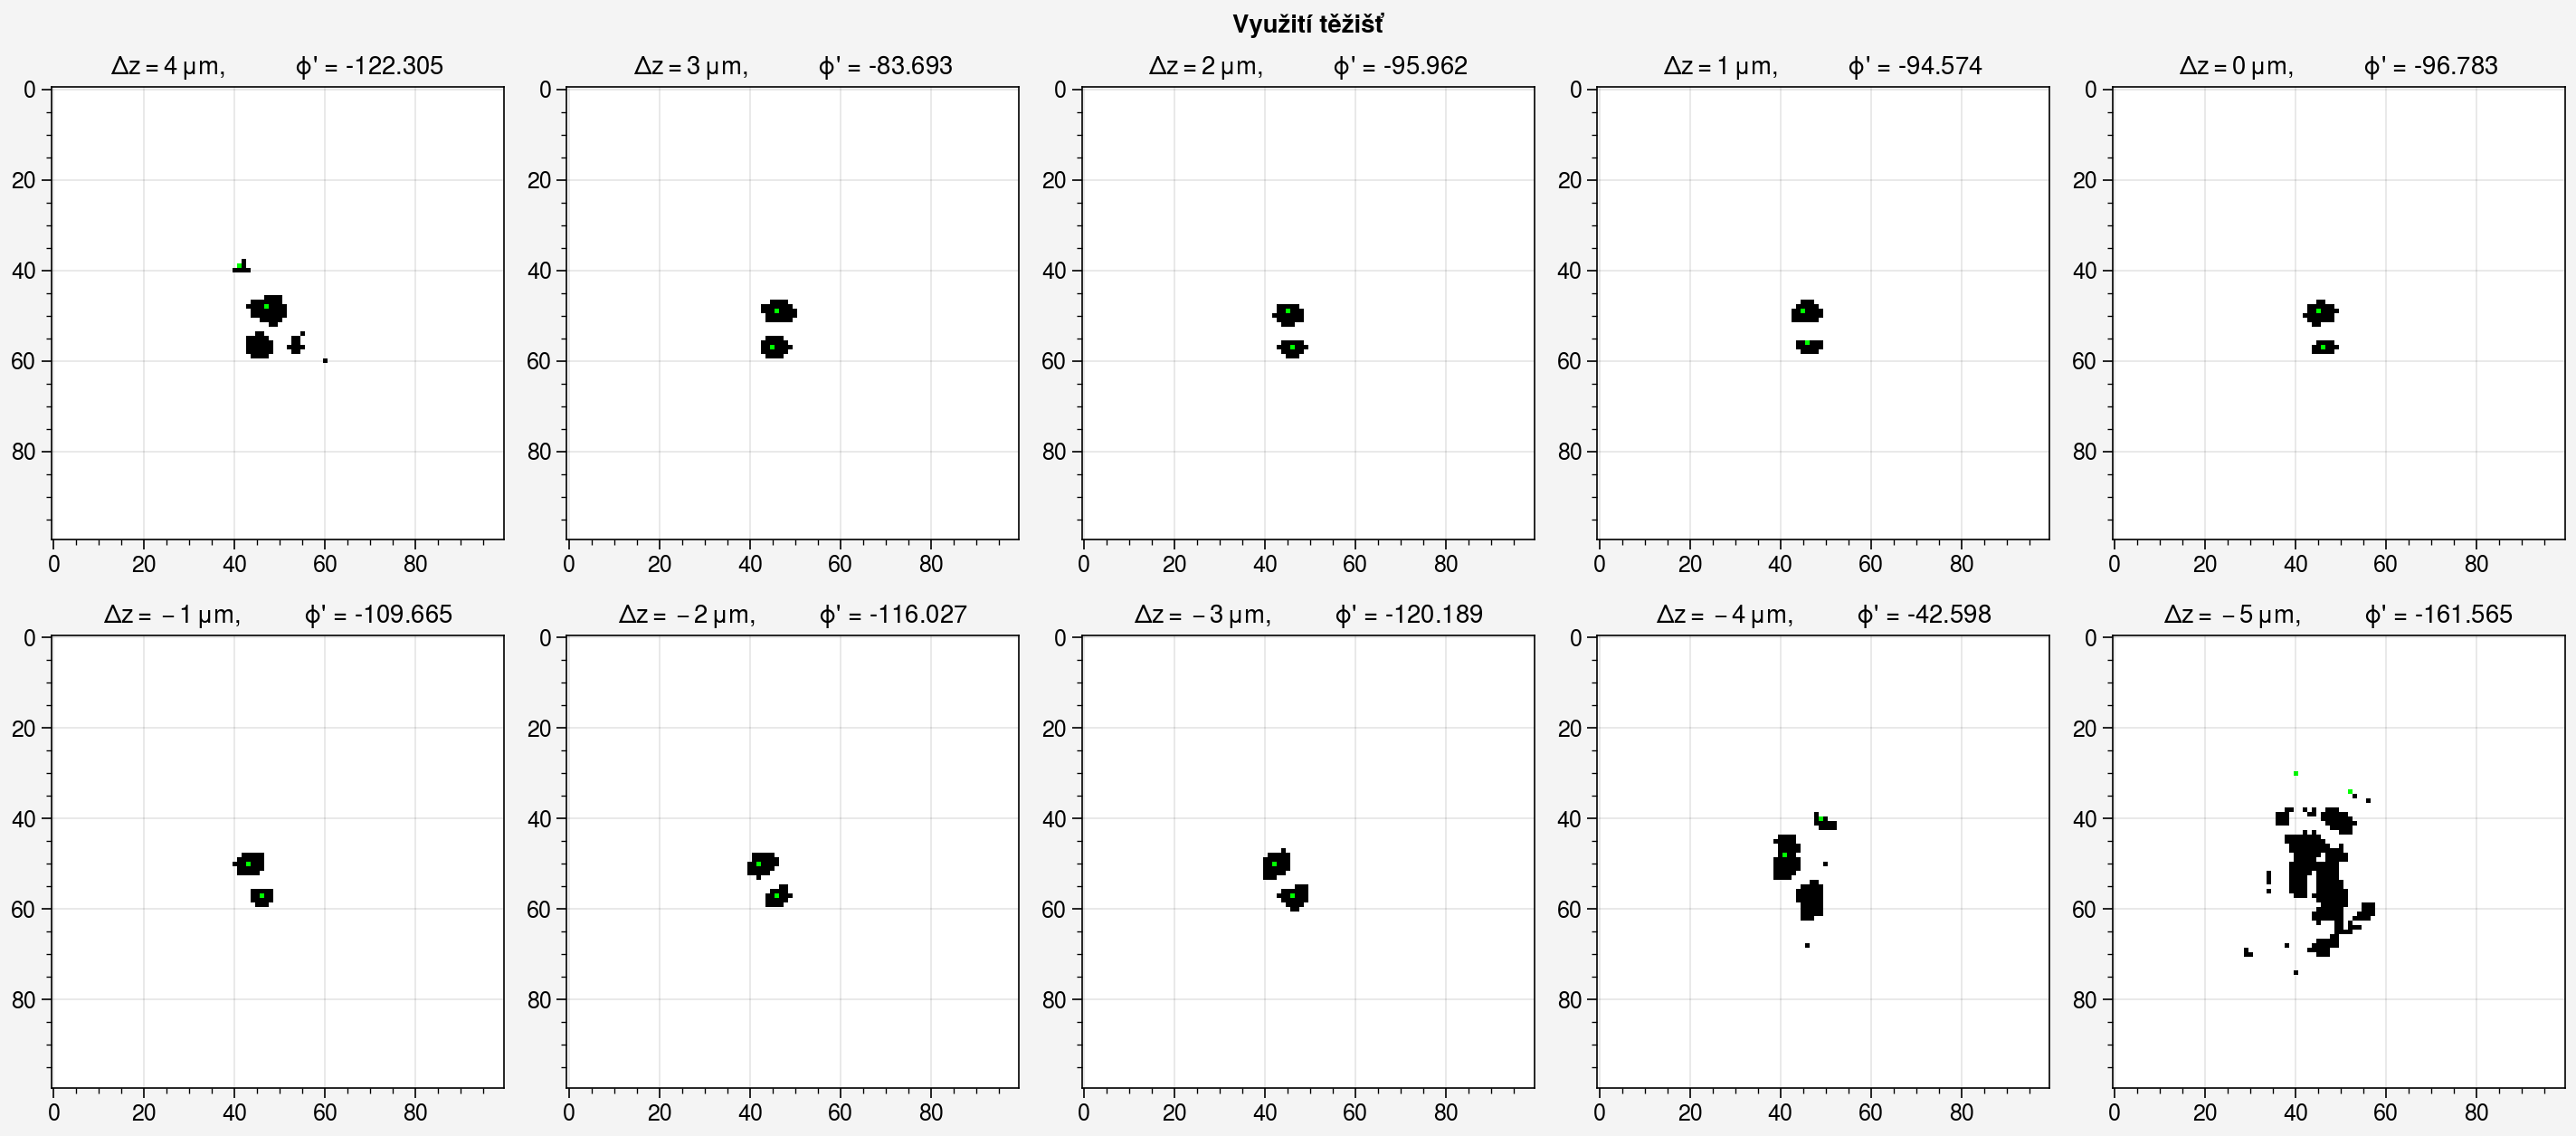

In [4]:
fig, axs = pplt.subplots(nrows=2, ncols=5, share=False,
                         suptitle="Využití těžišť")

angles = np.zeros(10)
defocus = np.zeros(10)

for i in range(-5, 5):
    defocus[i] = i
    filename = "test_imgs/" + str(i) + ".tiff"
    image = PSFrot.readImage(path=filename)
    image = PSFrot.threshold(image, intensity=0.4)
    c1, c2, angles[i], imC = PSFrot.centresOfMases(
        image, labeledImage=True, darkBlobs=True)
    axs[i//5, 4-i % 5].imshow(imC)
    axisTitle = "$\Delta z = " + \
        str(i) + " \,\mu m$, \t $\phi$' = " + str(round(angles[i], 3))
    axs[i//5, 4-i % 5].format(title=axisTitle)

fig.save("vysl_CoM.png", dpi=333)


Následně je vykreslena závislost defokusace na natočení PSF, která je ve vybraných bodech proložena regresní přímkou. 

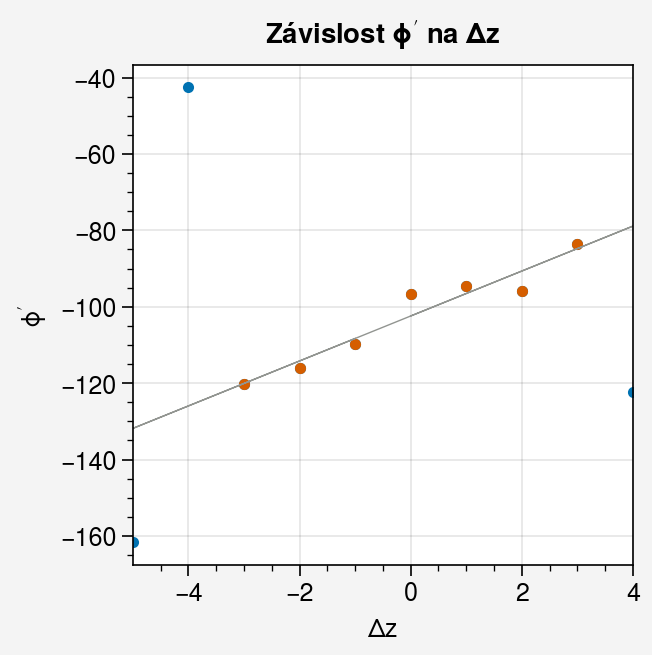

In [5]:
cond = (np.abs(defocus) < 4)
params = np.polyfit(defocus[cond], angles[cond], 1)
yFit = np.polyval(params, defocus)

fig = pplt.figure(suptitle="Závislost $\phi '$ na $\Delta z$ ")
ax = fig.subplot(xlabel="$\Delta z$", ylabel="$\phi '$ ")
ax.plot(defocus, angles, '.', lw=2)
ax.plot(defocus[cond], angles[cond], '.', lw=2)
ax.plot(defocus, yFit, lw=0.5, color='grey')
fig.save('defocus.png', dpi=333)


## Závěr

Při použití metody založené na hledání těžiště jednotlivých blobů lze vidět, žebyly poměrně dobře nalezeny středy a rotace DH PSF má lineární průběh vzhledem k defokusaci. Metoda přitozeně nefunguje pro velké defokusace u níchž nelze v obraze vidět dva jasné bloby.